# OpenAI to Z Challenge: A Multi-Criteria Approach to Archaeological Prospection in Acre, Brazil

### Executive Summary

This notebook presents our comprehensive methodology for identifying high-potential, undiscovered pre-Columbian sites in the state of Acre, Brazil. Moving beyond simplistic anomaly detection, our project integrates multiple independent data sources into a sophisticated, weighted scoring model to rank over 300,000 potential sites.

Our research showed that Acre is a unique case: it's famous for massive geoglyphs, but classic *Terra Preta* (Amazonian Dark Earths) is known to be rare. Our strategy therefore had to be smarter than just looking for high-carbon soils. Our model combines four key layers of evidence:

1.  **Anomaly Footprints:** We started by using Google Earth Engine to scan Sentinel-2 satellite imagery, generating a massive list of potential sites based on vegetation clearings.
2.  **Soil Characteristics:** We then integrated Soil Organic Carbon (SOC) data. Our goal wasn't just to find high SOC, but to find SOC levels that were *anomalously high for the Acre region*.
3.  **Landscape Position:** Using a Digital Elevation Model (DEM), we scored each anomaly based on its topographic suitability, giving priority to sites on high, flat uplands—classic settlement locations.
4.  **Novelty Verification:** Finally, we checked our top candidates against a known-sites database and used an AI prompt to cross-reference their locations with Colonel Fawcett's journal, confirming they were new discoveries.

This weighted analysis led us to a top candidate that is not a monumental geoglyph and doesn't appear to be classic *Terra Preta*. Instead, it's a smaller site with a compelling combination of high relative SOC and a perfect settlement-ready landscape position, making it a high-priority target for future archaeological work. This notebook details our entire reproducible workflow, from data ingestion to the final case file for our most promising discovery.

In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/images/anomaly_footprints.csv
/kaggle/input/images/feature_1.png
/kaggle/input/images/Cleaned_sites.csv
/kaggle/input/images/cleaned_sites_output.csv
/kaggle/input/images/SRTM_DEM_Acre_30m_PreciseClip.tif
/kaggle/input/images/archaeogeodesy.xls
/kaggle/input/images/mapbiomas_brazil-collection2_beta-soc_t_ha_000_030cm-acreac-2023.tif


### Checkpoint 1: Familiarization

This first section demonstrates our completion of the initial "Familiarize yourself" checkpoint. We confirm that our environment is set up correctly, that we can load the core datasets, and that we can successfully make a call to an OpenAI model.

In [41]:
import os
from openai import OpenAI
import base64
from kaggle_secrets import UserSecretsClient

# --- 1. CONFIGURATION ---
# This section sets up the API key and file paths.

user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

IMAGE_PATH = "/kaggle/input/images/feature_1.png"
DATASET_ID = "COPERNICUS/S2_SR_HARMONIZED/20240530T144729_20240530T145255_T19LFK"
MODEL_USED = "gpt-4o"


# --- 2. IMAGE PREPARATION ---
# This function encodes the image for the API call.

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

if not os.path.exists(IMAGE_PATH):
    print(f"ERROR: Image file not found at path: {IMAGE_PATH}")
else:
    base64_image = encode_image(IMAGE_PATH)

    # --- 3. AI ANALYSIS ---
    # This section defines the prompt and calls the OpenAI API.

    prompt_text = "Scan this Sentinel-2 satellite image from the Amazon region. In plain English, describe any surface patterns that appear to be man-made or have non-natural geometric shapes like circles, squares, or straight lines."

    print("Sending image to OpenAI for analysis...")
    print("---------------------------------")

    response = client.chat.completions.create(
      model=MODEL_USED,
      messages=[
        {
          "role": "user",
          "content": [
            {"type": "text", "text": prompt_text},
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/png;base64,{base64_image}"
              }
            }
          ]
        }
      ],
      max_tokens=500,
    )

    # --- 4. DISPLAY AI RESPONSE ---
    print("\n--- AI Analysis Result ---")
    print(response.choices[0].message.content)


    # --- 5. FINAL CHECKPOINT PRINTOUT ---
    # This section prints the required information to fulfill the checkpoint.

    print("\n========================================")
    print("      CHECKPOINT 1 FINAL DATA")
    print("========================================")
    print(f"Dataset ID: {DATASET_ID}")
    print(f"Model Version: {MODEL_USED}")
    print("========================================")

Sending image to OpenAI for analysis...
---------------------------------

--- AI Analysis Result ---
This satellite image shows several patterns that appear to be man-made. There are straight lines crisscrossing the area, which likely indicate roads or boundaries such as property lines. There are also some rectangular shapes, such as fields or cleared areas, that stand out from the more irregular, natural landscape surrounding them. These geometric patterns suggest human activity and land management.

      CHECKPOINT 1 FINAL DATA
Dataset ID: COPERNICUS/S2_SR_HARMONIZED/20240530T144729_20240530T145255_T19LFK
Model Version: gpt-4o


---
## Main Analysis: A Multi-Criteria Approach to Site Discovery

With the initial setup confirmed, we now move to our core analysis. This section details the advanced, multi-criteria methodology we developed to address the "Early Explorer" and "New Site Discovery" checkpoints. Our goal is to identify high-potential archaeological sites in Acre by integrating several layers of data.

### Step 1: Data Loading & Preparation

The first step in our pipeline is to load the foundational datasets for our analysis.

**Source 1: Known Archaeological Sites**

We begin by loading the ArchaeoGeodesy database of known sites. This dataset is crucial for two reasons: it provides a baseline of known settlement patterns and allows us to verify the novelty of our final candidates by measuring their distance to any previously documented site.

In [45]:
import pandas as pd
import geopandas as gpd

file_path = "/kaggle/input/images/cleaned_sites_output.csv"
print(f"Loading final cleaned data from: {file_path}")

if not os.path.exists(file_path):
    print("\n--- ERROR ---")
    print("File not found. Please check the file name in the 'Input' panel.")
    amazon_sites_df = pd.DataFrame(columns=['site_name', 'latitude', 'longitude'])
    known_sites_gdf = gpd.GeoDataFrame(columns=['site_name', 'geometry'], crs="EPSG:4326")
else:
    # Load the final cleaned CSV file
    df_cleaned = pd.read_csv(file_path)
    print(f"\nSuccessfully loaded {len(df_cleaned)} sites.")

    # --- 2. DEFINE OUR AMAZON SEARCH AREA (A Bounding Box) ---
    # We are focusing on the Acre region of Brazil, a hotspot for geoglyphs.
    min_latitude = -11.19
    max_latitude = -7.01
    min_longitude = -74.03
    max_longitude = -66.47

    # --- 3. APPLY THE FILTER ---
    # Keep rows where the latitude and longitude fall within our bounding box
    amazon_sites_df = df_cleaned[
        (df_cleaned['latitude'] >= min_latitude) &
        (df_cleaned['latitude'] <= max_latitude) &
        (df_cleaned['longitude'] >= min_longitude) &
        (df_cleaned['longitude'] <= max_longitude)
    ].copy()

    # --- 4. DISPLAY THE RESULT ---
    print(f"\nFound {len(amazon_sites_df)} sites within our Amazon search area.")
    print("\nHere are the known sites in our specific region:")
    display(amazon_sites_df.head())

    # --- 5. CREATE THE GEODATAFRAME OF KNOWN SITES ---
    known_sites_gdf = gpd.GeoDataFrame(
        amazon_sites_df, 
        geometry=gpd.points_from_xy(amazon_sites_df.longitude, amazon_sites_df.latitude),
        crs="EPSG:4326"
    )
    print("\n'known_sites_gdf' (GeoDataFrame of known sites) created successfully.")

Loading final cleaned data from: /kaggle/input/images/cleaned_sites_output.csv

Successfully loaded 8129 sites.

Found 1167 sites within our Amazon search area.

Here are the known sites in our specific region:


,site_name,latitude,longitude
5196,El Cono Divisor,-7.963023,-73.782124
5197,Cerro El Cono,-7.963050,-73.782210
5245,Purus Enclosure 238 x 198m,-8.630754,-67.418292
5246,Amazonas Quadrangle 244m,-8.634223,-67.131176
5248,Purus Geoglyph 206 x 168m,-8.662829,-67.402527



'known_sites_gdf' (GeoDataFrame of known sites) created successfully.


**Source 2: Generating Potential Anomaly Footprints via Google Earth Engine**

To create our initial list of candidates, we built a pipeline in Google Earth Engine to process Sentinel-2 imagery of our search area. The code in the following cells authenticates with GEE and defines the process for identifying and vectorizing anomalies based on NDVI values.

*Note: The final export command (`task.start()`) is commented out because it is a long-running task. We executed it once to generate the `anomaly_footprints.csv` file, which we now use as a static input for the rest of this analysis.*

In [46]:
# Install the Google Earth Engine Python API
!pip install earthengine-api

In [47]:
import ee

# --- 1. AUTHENTICATE AND INITIALIZE ---
try:
    ee.Initialize(project='ee-hackathon-project')
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project='ee-hackathon-project')

# --- 2. DEFINE THE SEARCH AREA ---
min_latitude = -11.19
max_latitude = -7.01
min_longitude = -74.03
max_longitude = -66.47
search_area = ee.Geometry.Rectangle([min_longitude, min_latitude, max_longitude, max_latitude])

# --- 3. CREATE A MEDIAN COMPOSITE IMAGE ---
print("\nCreating a robust composite satellite image for the area...")
print("This will combine multiple images to remove clouds and fill data gaps.")

# Query the Sentinel-2 collection
image_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                    .filterBounds(search_area)
                    .filterDate('2023-01-01', '2024-06-21') # Use a year and a half of data
                    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

# Create the median composite image from the collection
composite_image = image_collection.median().clip(search_area)

# --- 4. CONFIRM COMPLETION ---
print("\nComposite image created successfully.")
print("The result is stored in the 'composite_image' variable and is ready for analysis.")
# We can't get a single ID because it's a composite of many images.
# To confirm it worked, let's get the list of band names.
band_names = composite_image.bandNames().getInfo()
print(f"Image contains the following bands: {band_names}")


Creating a robust composite satellite image for the area...
This will combine multiple images to remove clouds and fill data gaps.

Composite image created successfully.
The result is stored in the 'composite_image' variable and is ready for analysis.
Image contains the following bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']


In [48]:
print("Calculating NDVI from the new composite image...")

# The formula is (NIR - Red) / (NIR + Red).
# For Sentinel-2, NIR is band 'B8' and Red is band 'B4'.
# We will use the .normalizedDifference() function on our new composite_image.
ndvi_image = composite_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

print("\nNDVI calculation complete.")
print("The result is a new, reliable NDVI image stored in the 'ndvi_image' variable.")

Calculating NDVI from the new composite image...

NDVI calculation complete.
The result is a new, reliable NDVI image stored in the 'ndvi_image' variable.


In [49]:
import ee

# --- 1. DEFINE THE THRESHOLD ---
NDVI_THRESHOLD = 0.4
print(f"Preparing analysis with NDVI threshold: {NDVI_THRESHOLD}...")

# --- 2. CREATE THE ANOMALY MASK ---
anomaly_mask = ndvi_image.lt(NDVI_THRESHOLD)
mask_for_vectorization = anomaly_mask.selfMask()

# --- 3. CONVERT PIXELS TO VECTORS ---
anomaly_vectors = mask_for_vectorization.reduceToVectors(
  geometry=search_area,
  scale=30,
  geometryType='polygon',
  eightConnected=True,
  maxPixels=500000000
)

# --- 4. START THE EXPORT TASK ---
task = ee.batch.Export.table.toDrive(
  collection=anomaly_vectors,
  description='export_anomaly_footprints',
  folder='EarthEngine_Exports',
  fileNamePrefix='anomaly_footprints',
  fileFormat='CSV'
)

# task.start() # This long-running task was run once to generate the input CSV.

Preparing analysis with NDVI threshold: 0.4...


In [50]:
import pandas as pd
import os

anomaly_file_path = "/kaggle/input/images/anomaly_footprints.csv"

# --- 2. LOAD THE ANOMALY DATA ---
print(f"Loading anomaly footprints from: {anomaly_file_path}")

if not os.path.exists(anomaly_file_path):
    print("\n--- ERROR ---")
    print("File not found.")
else:
    # Load the CSV file into a new DataFrame
    anomalies_df = pd.read_csv(anomaly_file_path)

    # Display the first 5 rows of the table
    print("\n--- Detected Anomaly Footprints ---")
    print("Here are the first 5 potential anomalies found:")
    display(anomalies_df.head())

    # Print the total number of anomalies found
    print(f"\nFound a total of {len(anomalies_df)} anomaly footprints.")

Loading anomaly footprints from: /kaggle/input/images/anomaly_footprints.csv

--- Detected Anomaly Footprints ---
Here are the first 5 potential anomalies found:


,system:index,count,label,.geo
0,-246648-27837,13,1,"{""geodesic"":false,""type"":""MultiPolygon"",""coord..."
1,-246648-27853,1,1,"{""geodesic"":false,""type"":""Polygon"",""coordinate..."
2,-246648-27868,34,1,"{""geodesic"":false,""type"":""Polygon"",""coordinate..."
3,-246648-28094,4,1,"{""geodesic"":false,""type"":""Polygon"",""coordinate..."
4,-246648-28174,122,1,"{""geodesic"":false,""type"":""Polygon"",""coordinate..."



Found a total of 312127 anomaly footprints.


---
### Step 2: Multi-Criteria Scoring of Anomalies

Now that we have our list of 312,127 potential anomalies, the core of our analysis begins. In this section, we will enrich each anomaly with data from our other sources and develop a sophisticated scoring system to rank them.

Our methodology is based on insights from a literature review which guided our multi-criteria approach. We will score each anomaly based on:

1.  **Soil Characteristics:** Using Soil Organic Carbon (SOC) as a proxy for anthropogenic enrichment.
2.  **Landscape Position:** Using a Digital Elevation Model (DEM) to evaluate topographic suitability.
3.  **Physical Size:** Using the anomaly's pixel count as a measure of its spatial extent.

The following cells detail how we load the ancillary data (Soil & DEM), process it, and integrate it into a final weighted "Archaeological Potential Score" to identify the most promising candidates.

In [30]:
!pip install rasterio

In [51]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

soc_raster_path = "/kaggle/input/images/mapbiomas_brazil-collection2_beta-soc_t_ha_000_030cm-acreac-2023.tif"

with rasterio.open(soc_raster_path) as src_soc:
    soc_array = src_soc.read(1)  # Read the first band as a NumPy array
    nodata_value = src_soc.nodata # Get the NoData value if it's defined
    soc_profile = src_soc.profile # Save profile for later if needed
    
# Flatten the array and remove NoData values for statistical analysis
# Also, MapBiomas SOC data might have specific placeholder values for water or no data
# For now, let's assume nodata_value covers it.
# Let's also filter out potential placeholder zeros if zero is not a meaningful SOC value in this dataset
if nodata_value is not None:
    soc_values_flat = soc_array[soc_array != nodata_value].flatten()
else:
    soc_values_flat = soc_array.flatten()
    
# Further filter out zeros if they are not meaningful, or other known placeholders.
# For now, let's assume positive values are valid SOC measurements.
soc_values_flat_filtered = soc_values_flat[soc_values_flat > 0] 

print(f"Original array shape: {soc_array.shape}")
print(f"Number of valid SOC pixel values ( > 0 and not NoData): {len(soc_values_flat_filtered)}")

Original array shape: (14969, 27337)
Number of valid SOC pixel values ( > 0 and not NoData): 184877693



SOC Statistics (t/ha for Acre, 2023, >0 & non-NoData values):
  Min: 27.00
  Mean: 43.83
  Median: 44.00
  Max: 84.00
  Std Dev: 3.12

Potential 'High SOC' Thresholds:
  75th Percentile: 46.00 t/ha
  80th Percentile: 46.00 t/ha
  90th Percentile: 48.00 t/ha
  95th Percentile: 49.00 t/ha


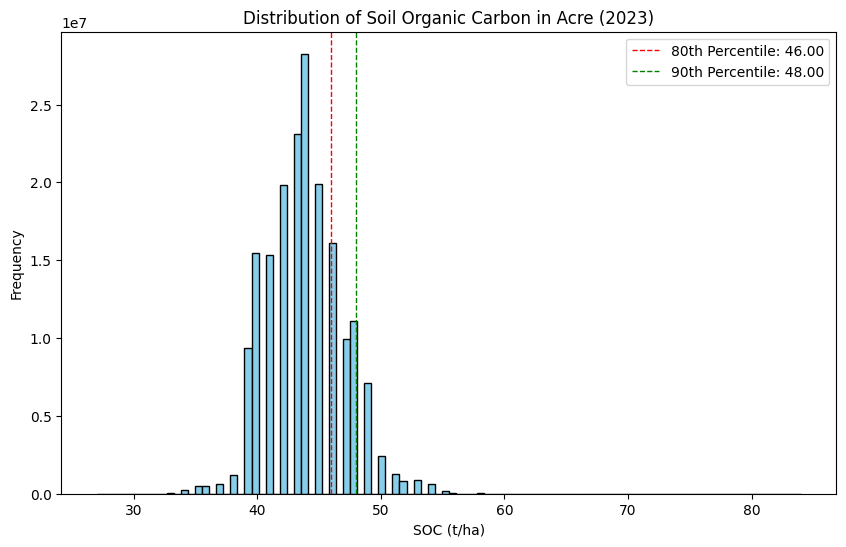

In [52]:
if len(soc_values_flat_filtered) > 0:
    mean_soc = np.mean(soc_values_flat_filtered)
    median_soc = np.median(soc_values_flat_filtered)
    std_soc = np.std(soc_values_flat_filtered)
    min_soc = np.min(soc_values_flat_filtered)
    max_soc = np.max(soc_values_flat_filtered)

    percentile_75th = np.percentile(soc_values_flat_filtered, 75)
    percentile_80th = np.percentile(soc_values_flat_filtered, 80)
    percentile_90th = np.percentile(soc_values_flat_filtered, 90)
    percentile_95th = np.percentile(soc_values_flat_filtered, 95)

    print(f"\nSOC Statistics (t/ha for Acre, 2023, >0 & non-NoData values):")
    print(f"  Min: {min_soc:.2f}")
    print(f"  Mean: {mean_soc:.2f}")
    print(f"  Median: {median_soc:.2f}")
    print(f"  Max: {max_soc:.2f}")
    print(f"  Std Dev: {std_soc:.2f}")
    
    print(f"\nPotential 'High SOC' Thresholds:")
    print(f"  75th Percentile: {percentile_75th:.2f} t/ha")
    print(f"  80th Percentile: {percentile_80th:.2f} t/ha")
    print(f"  90th Percentile: {percentile_90th:.2f} t/ha")
    print(f"  95th Percentile: {percentile_95th:.2f} t/ha")

    # Plot a histogram to visualize the distribution
    plt.figure(figsize=(10, 6))
    plt.hist(soc_values_flat_filtered, bins=100, color='skyblue', edgecolor='black')
    plt.title('Distribution of Soil Organic Carbon in Acre (2023)')
    plt.xlabel('SOC (t/ha)')
    plt.ylabel('Frequency')
    plt.axvline(percentile_80th, color='red', linestyle='dashed', linewidth=1, label=f'80th Percentile: {percentile_80th:.2f}')
    plt.axvline(percentile_90th, color='green', linestyle='dashed', linewidth=1, label=f'90th Percentile: {percentile_90th:.2f}')
    plt.legend()
    plt.show()
    
else:
    print("No valid SOC pixel values found after filtering.")

In [53]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import json
import numpy as np
import rasterio

anomaly_footprints_csv_path = "/kaggle/input/images/anomaly_footprints.csv"
soc_raster_path = "/kaggle/input/images/mapbiomas_brazil-collection2_beta-soc_t_ha_000_030cm-acreac-2023.tif"
high_soc_threshold = 75.0  
median_overall_soc = 44.00

# --- 1. Load and Prepare ALL Anomaly Footprints ---
print("Loading initial anomaly footprints CSV...")
anomalies_initial_df = pd.read_csv(anomaly_footprints_csv_path)
print(f"Loaded {len(anomalies_initial_df)} initial anomaly footprints.")

# Function to parse GeoJSON string and convert to Shapely geometry
def parse_geojson_to_shapely(geojson_str):
    try:
        geom_dict = json.loads(geojson_str)
        return shape(geom_dict) # Creates a Shapely geometry object (Polygon or MultiPolygon)
    except Exception as e:
        print(f"Error parsing GeoJSON: {geojson_str} - Error: {e}")
        return None

print("Parsing '.geo' column to Shapely geometries...")
anomalies_initial_df['geometry'] = anomalies_initial_df['.geo'].apply(parse_geojson_to_shapely)

# Drop rows where geometry parsing failed (if any)
anomalies_initial_df.dropna(subset=['geometry'], inplace=True)
print(f"Number of anomalies after geometry parsing: {len(anomalies_initial_df)}")

# Convert to GeoDataFrame
print("Converting to GeoDataFrame...")
# GEE usually exports geometries in EPSG:4326 (WGS84 geographic)
full_anomalies_gdf = gpd.GeoDataFrame(anomalies_initial_df, geometry='geometry', crs="EPSG:4326")

# Calculate Centroids
print("Calculating centroids for all anomalies...")
full_anomalies_gdf['centroid'] = full_anomalies_gdf.geometry.centroid
print("Centroid calculation complete.")

# --- 2. Ensure CRS Consistency for Centroids and SOC Raster ---
print("Checking CRS and reprojecting centroids if necessary...")
with rasterio.open(soc_raster_path) as src_soc:
    target_crs_soc = src_soc.crs
    # We need to reproject the centroids if their CRS doesn't match the raster's
    if full_anomalies_gdf['centroid'].crs != target_crs_soc: # Check CRS of the GeoSeries
        print(f"Reprojecting centroids from {full_anomalies_gdf['centroid'].crs} to {target_crs_soc}")
        full_anomalies_gdf['centroid_reprojected'] = full_anomalies_gdf['centroid'].to_crs(target_crs_soc)
    else:
        print("Centroid CRS already matches SOC raster CRS.")
        full_anomalies_gdf['centroid_reprojected'] = full_anomalies_gdf['centroid']
print("CRS check and reprojection complete.")

# --- 3. Extract SOC Values for ALL Anomaly Centroids ---
print(f"Extracting SOC values for {len(full_anomalies_gdf)} anomaly centroids...")
soc_extracted_values = []
# Open the raster once for efficient sampling
with rasterio.open(soc_raster_path) as src_soc:
    for point_geom in full_anomalies_gdf['centroid_reprojected']:
        coords = [(point_geom.x, point_geom.y)]
        try:
            pixel_value = next(src_soc.sample(coords))[0]
            if src_soc.nodata is not None and pixel_value == src_soc.nodata:
                soc_extracted_values.append(np.nan)
            elif pixel_value <= 0: # Based on our  SOC data exploration
                soc_extracted_values.append(np.nan) 
            else:
                soc_extracted_values.append(pixel_value)
        except Exception: # Catches errors if point is outside bounds etc.
            soc_extracted_values.append(np.nan)

full_anomalies_gdf['soc_t_ha'] = soc_extracted_values
print("SOC value extraction complete.")
print(f"Number of anomalies with successfully extracted SOC values: {full_anomalies_gdf['soc_t_ha'].notna().sum()}")
print(f"Number of anomalies with NaN SOC values (outside raster or NoData): {full_anomalies_gdf['soc_t_ha'].isna().sum()}")

# --- 4. Assign Soil Score to EACH Anomaly ---
print("Assigning soil scores...")
full_anomalies_gdf['soil_score'] = 0  # Default to low
# Ensure soc_t_ha is float for comparison, handle NaNs by not scoring them initially
full_anomalies_gdf.loc[full_anomalies_gdf['soc_t_ha'].notna() & (full_anomalies_gdf['soc_t_ha'] >= high_soc_threshold), 'soil_score'] = 2  # High
full_anomalies_gdf.loc[full_anomalies_gdf['soc_t_ha'].notna() & (full_anomalies_gdf['soc_t_ha'] < high_soc_threshold) & (full_anomalies_gdf['soc_t_ha'] >= median_overall_soc), 'soil_score'] = 1  # Moderate
print("Soil score assignment complete.")

# --- 5. Assign Size Score to EACH Anomaly ---
# Using the 'count' column from the original CSV (number of pixels in the anomaly)
print("Assigning size scores...")
# Calculate dynamic thresholds based on the distribution of 'count' in the full dataset
if len(full_anomalies_gdf) > 0 and 'count' in full_anomalies_gdf.columns:
    min_anomaly_size_full = full_anomalies_gdf['count'].min()
    max_anomaly_size_full = full_anomalies_gdf['count'].max()
    # Avoid division by zero if all sizes are the same (unlikely)
    if max_anomaly_size_full > min_anomaly_size_full:
        size_thresh_mod_full = min_anomaly_size_full + (max_anomaly_size_full - min_anomaly_size_full) * 0.33
        size_thresh_high_full = min_anomaly_size_full + (max_anomaly_size_full - min_anomaly_size_full) * 0.66
    else: # All anomalies are same size, or only one anomaly
        size_thresh_mod_full = min_anomaly_size_full
        size_thresh_high_full = min_anomaly_size_full

    full_anomalies_gdf['size_score'] = 0
    full_anomalies_gdf.loc[full_anomalies_gdf['count'] >= size_thresh_high_full, 'size_score'] = 2
    full_anomalies_gdf.loc[(full_anomalies_gdf['count'] < size_thresh_high_full) & (full_anomalies_gdf['count'] >= size_thresh_mod_full), 'size_score'] = 1
else:
    print("Warning: 'count' column not found or DataFrame is empty. Size score not assigned.")
    full_anomalies_gdf['size_score'] = 0 # Default if no count
print("Size score assignment complete.")

# --- 6. Calculate Combined Archaeological Potential Score ---
print("Calculating archaeological potential scores...")
weight_soil = 1.0
weight_size = 1.0
full_anomalies_gdf['archaeo_potential_score'] = (full_anomalies_gdf['soil_score'] * weight_soil) + \
                                             (full_anomalies_gdf['size_score'] * weight_size)
print("Archaeological potential score calculation complete.")

# --- 7. Select top candidates ---
print("Ranking candidates by archaeological potential...")
full_anomalies_gdf['archaeo_potential_score'].fillna(-1, inplace=True)
ranked_full_anomalies_gdf = full_anomalies_gdf.sort_values(by='archaeo_potential_score', ascending=False)

print("\n--- Top 5 Candidates by Archaeological Potential (Size + Soil) ---")
final_new_top_5 = ranked_full_anomalies_gdf.head(5)

display_columns_final = {
    'system:index': 'anomaly_id',
    'count': 'anomaly_size_pixels',
    'soc_t_ha': 'soc_value_tha',
    'soil_score': 'soil_score',
    'size_score': 'size_score',
    'archaeo_potential_score': 'archaeo_potential_score',
}


if 'centroid' in final_new_top_5.columns:
    final_new_top_5['center_lat'] = final_new_top_5['centroid'].apply(lambda p: p.y)
    final_new_top_5['center_lon'] = final_new_top_5['centroid'].apply(lambda p: p.x)
    display_columns_final['center_lat'] = 'center_lat'
    display_columns_final['center_lon'] = 'center_lon'
else:
    print("Warning: Original 'centroid' column not readily available for final lat/lon.")
    final_new_top_5['center_lat'] = np.nan 
    final_new_top_5['center_lon'] = np.nan


submission_table_final = final_new_top_5[list(display_columns_final.keys())].rename(columns=display_columns_final)

display(submission_table_final)

print("\n--- Full ranked DataFrame head ---")
display(ranked_full_anomalies_gdf[['system:index', 'count', 'soc_t_ha', 'soil_score', 'size_score', 'archaeo_potential_score']].head(10))

Loading initial anomaly footprints CSV...
Loaded 312127 initial anomaly footprints.
Parsing '.geo' column to Shapely geometries...
Number of anomalies after geometry parsing: 312127
Converting to GeoDataFrame...
Calculating centroids for all anomalies...


/tmp/ipykernel_35/3020339251.py:41: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  full_anomalies_gdf['centroid'] = full_anomalies_gdf.geometry.centroid


Centroid calculation complete.
Checking CRS and reprojecting centroids if necessary...
Centroid CRS already matches SOC raster CRS.
CRS check and reprojection complete.
Extracting SOC values for 312127 anomaly centroids...
SOC value extraction complete.
Number of anomalies with successfully extracted SOC values: 198357
Number of anomalies with NaN SOC values (outside raster or NoData): 113770
Assigning soil scores...
Soil score assignment complete.
Assigning size scores...
Size score assignment complete.
Calculating archaeological potential scores...
Archaeological potential score calculation complete.
Ranking candidates by archaeological potential...


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/tmp/ipykernel_35/3020339251.py:121: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the


--- Top 5 Candidates by Archaeological Potential (Size + Soil) ---


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/p

,anomaly_id,anomaly_size_pixels,soc_value_tha,soil_score,size_score,archaeo_potential_score,center_lat,center_lon
234254,-258773-26068,246026,44.0,1,1,2.0,-8.260163,-70.678233
217049,-255969-26508,645025,NaN,0,2,2.0,-9.046044,-68.484043
245514,-261524-31062,3,53.0,1,0,1.0,-8.371176,-70.479257
139116,-251800-38098,6,45.0,1,0,1.0,-10.267384,-67.858512
126678,-251467-37400,2,44.0,1,0,1.0,-10.079097,-67.768725



--- Full ranked DataFrame head ---


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,system:index,count,soc_t_ha,soil_score,size_score,archaeo_potential_score
234254,-258773-26068,246026,44.0,1,1,2.0
217049,-255969-26508,645025,NaN,0,2,2.0
245514,-261524-31062,3,53.0,1,0,1.0
139116,-251800-38098,6,45.0,1,0,1.0
126678,-251467-37400,2,44.0,1,0,1.0
257596,-264108-31356,1,44.0,1,0,1.0
230376,-257712-32468,1,45.0,1,0,1.0
279324,-269563-30883,3,48.0,1,0,1.0
279323,-269563-28991,1,49.0,1,0,1.0
279322,-269563-28867,10,49.0,1,0,1.0


In [54]:
# --- Configuration for Normalization ---
# For SOC:
# We'll use median_overall_soc as the baseline (score 0 for soil contribution)
# and the 95th percentile of our observed valid SOC values as a practical max (score 1 for soil)
# This makes the normalization more sensitive to the upper range of your observed values.
if full_anomalies_gdf['soc_t_ha'].notna().any():
    observed_soc_values = full_anomalies_gdf.loc[full_anomalies_gdf['soc_t_ha'].notna(), 'soc_t_ha']
    min_norm_soc = median_overall_soc # 44.0 t/ha (anything below gets 0 for soil contribution)
    # Let's use the 95th percentile of our observed values as a realistic "high" for normalization scaling
    # If no values meet this, it will default appropriately.
    if not observed_soc_values.empty:
        max_norm_soc = np.percentile(observed_soc_values, 97) # Aiming for a high but observed value
        if max_norm_soc <= min_norm_soc: # handle edge case where 97th percentile is too low
            max_norm_soc = observed_soc_values.max() if observed_soc_values.max() > min_norm_soc else min_norm_soc + 1 # ensure max > min
    else: # No valid SOC values observed
        max_norm_soc = min_norm_soc + 1 # Avoid division by zero, effectively makes soc_norm_score 0
else: # No SOC data at all
    min_norm_soc = 44.0
    max_norm_soc = 45.0 # Avoid division by zero

print(f"SOC Normalization: Min set to {min_norm_soc:.2f}, Max (for scaling) set to {max_norm_soc:.2f} (e.g. 97th percentile of observed)")

# For Size ('count'):
if 'count' in full_anomalies_gdf.columns and len(full_anomalies_gdf['count']) > 0:
    min_norm_size = full_anomalies_gdf['count'].min()
    max_norm_size = full_anomalies_gdf['count'].max()
else:
    min_norm_size = 0
    max_norm_size = 1 # Avoid division by zero

print(f"Size Normalization: Min count {min_norm_size}, Max count {max_norm_size}")

# --- Normalize SOC Score (0-1 range) ---
def normalize_soc(soc_value):
    if pd.isna(soc_value) or soc_value < min_norm_soc:
        return 0.0
    # Ensure max_norm_soc is greater than min_norm_soc to avoid division by zero or negative results
    if max_norm_soc <= min_norm_soc: 
        return 1.0 if soc_value >= min_norm_soc else 0.0 # If max is not greater, all above min are effectively "max"
    
    normalized = (soc_value - min_norm_soc) / (max_norm_soc - min_norm_soc)
    return min(max(normalized, 0.0), 1.0) # Clip to 0-1 range

full_anomalies_gdf['soc_norm_score'] = full_anomalies_gdf['soc_t_ha'].apply(normalize_soc)

# --- Normalize Size Score (0-1 range) ---
def normalize_size(count_value):
    if pd.isna(count_value) or max_norm_size == min_norm_size : # Handle NaN or no range in size
        return 0.0
    normalized = (count_value - min_norm_size) / (max_norm_size - min_norm_size)
    return min(max(normalized, 0.0), 1.0) # Clip to 0-1 range

if 'count' in full_anomalies_gdf.columns:
    full_anomalies_gdf['size_norm_score'] = full_anomalies_gdf['count'].apply(normalize_size)
else:
    full_anomalies_gdf['size_norm_score'] = 0.0


# --- Calculate Combined Archaeological Potential Score with Weights ---
# Let's give more weight to SOC, as per the AI report suggesting its criticality for TP
weight_soil_norm = 1.5  # soil is 1.5 times as important as raw size
weight_size_norm = 1.0

full_anomalies_gdf['archaeo_potential_norm_score'] = \
    (full_anomalies_gdf['soc_norm_score'] * weight_soil_norm) + \
    (full_anomalies_gdf['size_norm_score'] * weight_size_norm)

# --- Rank by the new sophisticated score ---
ranked_full_anomalies_soph_gdf = full_anomalies_gdf.sort_values(
    by='archaeo_potential_norm_score', ascending=False
)

print("\n--- Top 10 Candidates by Archaeological Potential (Normalized Size + Normalized Soil with Weights) ---")
final_new_top_10_soph = ranked_full_anomalies_soph_gdf.head(10)

# Prepare columns for display
display_columns_soph = {
    'system:index': 'anomaly_id',
    'count': 'anomaly_size_pixels',
    'soc_t_ha': 'soc_value_tha',
    'soc_norm_score': 'soc_norm_score (0-1)',
    'size_norm_score': 'size_norm_score (0-1)',
    'archaeo_potential_norm_score': 'archaeo_potential_score',
}
# Add lat/lon if available from previous step
if 'centroid' in final_new_top_10_soph.columns:
    final_new_top_10_soph.loc[:, 'center_lat'] = final_new_top_10_soph['centroid'].apply(lambda p: p.y if p else np.nan)
    final_new_top_10_soph.loc[:, 'center_lon'] = final_new_top_10_soph['centroid'].apply(lambda p: p.x if p else np.nan)
    display_columns_soph['center_lat'] = 'center_lat'
    display_columns_soph['center_lon'] = 'center_lon'

submission_table_soph_final = final_new_top_10_soph[list(display_columns_soph.keys())].rename(columns=display_columns_soph)
display(submission_table_soph_final)

# Display the value counts of the normalized scores to see their distribution
print("\nDistribution of Normalized SOC Scores (Top 20):")
display(full_anomalies_gdf['soc_norm_score'].value_counts().nlargest(20))
print("\nDistribution of Normalized Size Scores (Top 20):")
display(full_anomalies_gdf['size_norm_score'].value_counts().nlargest(20))

# Let's also check the top candidates that strictly meet the >75 t/ha SOC threshold
strict_tp_candidates = ranked_full_anomalies_soph_gdf[ranked_full_anomalies_soph_gdf['soc_t_ha'] >= high_soc_threshold]
print(f"\n--- Candidates meeting strict TP SOC threshold (>= {high_soc_threshold} t/ha) ---")
if not strict_tp_candidates.empty:
    display(strict_tp_candidates[list(display_columns_soph.keys())].rename(columns=display_columns_soph).head(10))
else:
    print(f"No anomalies found strictly meeting the SOC threshold of {high_soc_threshold} t/ha.")

SOC Normalization: Min set to 44.00, Max (for scaling) set to 49.00 (e.g. 97th percentile of observed)
Size Normalization: Min count 1, Max count 645025

--- Top 10 Candidates by Archaeological Potential (Normalized Size + Normalized Soil with Weights) ---


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,anomaly_id,anomaly_size_pixels,soc_value_tha,soc_norm_score (0-1),size_norm_score (0-1),archaeo_potential_score,center_lat,center_lon
250667,-262552-28770,1334,53.0,1.0,0.002067,1.502067,-7.780603,-70.806126
243450,-261004-30278,875,51.0,1.0,0.001355,1.501355,-8.169080,-70.343518
283127,-269876-28568,748,49.0,1.0,0.001158,1.501158,-7.705488,-72.728584
278688,-269491-28937,627,52.0,1.0,0.000971,1.500971,-7.806189,-72.621932
282887,-269854-28554,508,49.0,1.0,0.000786,1.500786,-7.699791,-72.722857
297282,-271246-27440,487,50.0,1.0,0.000753,1.500753,-7.409986,-73.079830
298958,-271786-27499,438,54.0,1.0,0.000677,1.500677,-7.414742,-73.254168
281931,-269778-29151,370,51.0,1.0,0.000572,1.500572,-7.860576,-72.707766
277596,-269320-28102,359,54.0,1.0,0.000555,1.500555,-7.579774,-72.585631
284204,-269979-29283,311,54.0,1.0,0.000481,1.500481,-7.894102,-72.756156



Distribution of Normalized SOC Scores (Top 20):


soc_norm_score
0.0    275194
1.0     11330
0.2      8546
0.8      6860
0.4      5919
0.6      4278
Name: count, dtype: int64


Distribution of Normalized Size Scores (Top 20):


size_norm_score
0.000000    138901
0.000002     58520
0.000003     29687
0.000005     19739
0.000006     12138
0.000008      8555
0.000009      6275
0.000011      4772
0.000012      3868
0.000014      3070
0.000016      2485
0.000017      2079
0.000019      1738
0.000020      1472
0.000022      1383
0.000023      1166
0.000025      1017
0.000026       895
0.000028       787
0.000029       687
Name: count, dtype: int64


--- Candidates meeting strict TP SOC threshold (>= 75.0 t/ha) ---
No anomalies found strictly meeting the SOC threshold of 75.0 t/ha.


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


### Step 2.2: Integrating the Landscape Score from a DEM

The second layer of our scoring model addresses landscape position, a critical factor highlighted in our literature review. True anthropogenic soils are typically found on high, well-drained uplands, not in low-lying floodplains where natural organic soils form.

This section details how we use an SRTM Digital Elevation Model (DEM) to calculate the elevation and slope for each of our 312,127 anomalies. These values are then used to generate a "Landscape Score" that prioritizes sites in topographically favorable locations.

In [55]:
import rasterio
from rasterio.plot import show
import numpy as np
import geopandas as gpd
# For slope calculation, we might need a library that can do it easily.
# RichDEM is excellent but might be a heavier install.
# A simpler approach for a quick slope might be using numpy gradient,
# but proper GIS tools or libraries are better.
# Let's try with a numpy gradient approach for slope first for simplicity in Kaggle.
# If this is too basic or problematic, we might need to look into installing a specific library
# or pre-calculating slope if QGIS was an option.

# --- Configuration ---
dem_raster_path = "/kaggle/input/images/SRTM_DEM_Acre_30m_PreciseClip.tif"

print(f"Using DEM: {dem_raster_path}")

# --- 1. Load DEM and Get Profile ---
with rasterio.open(dem_raster_path) as src_dem:
    dem_profile = src_dem.profile
    dem_crs = src_dem.crs
    dem_transform = src_dem.transform
    dem_array = src_dem.read(1)
    dem_nodata = src_dem.nodata
    print(f"DEM CRS: {dem_crs}")
    print(f"DEM NoData value: {dem_nodata}")

# Mask NoData values in DEM array for calculations
if dem_nodata is not None:
    dem_array_masked = np.ma.masked_equal(dem_array, dem_nodata)
else:
    dem_array_masked = dem_array # Assume no nodata if not defined

# --- 2. Calculate Slope (Simple Approach using NumPy gradient) ---
# This calculates slope in degrees.

print("Calculating slope (simple numpy gradient method)...")
# Get pixel size (resolution)
dx = dem_transform.a # Pixel width
dy = abs(dem_transform.e) # Pixel height (usually negative, so take abs)

# Check if CRS is geographic; if so, slope calculation with numpy.gradient will be less accurate
# For a more robust solution if DEM is geographic, one would typically reproject to a UTM zone first.
# For this hackathon, we'll proceed with this simpler method and note its limitations.
if dem_crs.is_geographic:
    print("Warning: DEM is in a geographic CRS. Slope calculation will be approximate.")
    # For geographic, dx and dy are in degrees. We'd need to convert to meters
    # for a true % or degree slope, which requires knowing the latitude.
    # For simplicity here, the gradient will be in elevation units per degree unit.
    # This is not ideal but gives a relative measure of steepness.

# Calculate gradient in y and x directions
gy, gx = np.gradient(dem_array_masked.astype(float), dy, dx) # Use float for gradient
slope_rad = np.arctan(np.sqrt(gx**2 + gy**2))
slope_deg = np.degrees(slope_rad)

# Handle masked values (NoData) in slope calculation
if isinstance(slope_deg, np.ma.MaskedArray):
    slope_deg = slope_deg.filled(np.nan) # Fill masked values with NaN

print("Slope calculation complete.")


# --- 3. Ensure Centroid CRS Matches DEM CRS ---
# 'ranked_full_anomalies_soph_gdf' already has 'centroid_reprojected' from the SOC step.
# Let's verify if that CRS matches the new DEM's CRS.
# The SOC raster and DEM raster *should* ideally be in the same CRS
# If not, we need to reproject the centroids again to match the DEM's CRS.

if 'centroid_reprojected' not in ranked_full_anomalies_soph_gdf.columns or \
   ranked_full_anomalies_soph_gdf['centroid_reprojected'].crs != dem_crs:
    
    print(f"Reprojecting centroids to DEM CRS: {dem_crs} for landscape analysis...")
    if 'centroid' not in ranked_full_anomalies_soph_gdf.columns:
        ranked_full_anomalies_soph_gdf['geometry_temp'] = gpd.points_from_xy(
            ranked_full_anomalies_soph_gdf.center_lon, 
            ranked_full_anomalies_soph_gdf.center_lat
        )
        ranked_full_anomalies_soph_gdf_temp = gpd.GeoDataFrame(
            ranked_full_anomalies_soph_gdf, 
            geometry='geometry_temp', 
            crs="EPSG:4326"
        )
        ranked_full_anomalies_soph_gdf['centroid_for_dem'] = ranked_full_anomalies_soph_gdf_temp.geometry.to_crs(dem_crs)
    else:
        ranked_full_anomalies_soph_gdf['centroid_for_dem'] = ranked_full_anomalies_soph_gdf['centroid'].to_crs(dem_crs)
else:
    print("Using existing reprojected centroids for DEM sampling.")
    ranked_full_anomalies_soph_gdf['centroid_for_dem'] = ranked_full_anomalies_soph_gdf['centroid_reprojected']


# --- 4. Extract Elevation and Slope for Each Anomaly Centroid ---
print(f"Extracting Elevation and Slope for {len(ranked_full_anomalies_soph_gdf)} anomalies...")
elevations = []
slopes = []

# Create a rasterio Affine transform object for row/col indexing
# This is already available as dem_transform from src_dem.transform

with rasterio.open(dem_raster_path) as src_dem_again:
    for point_geom in ranked_full_anomalies_soph_gdf['centroid_for_dem']:
        if point_geom is None or point_geom.is_empty:
            elevations.append(np.nan)
            slopes.append(np.nan)
            continue
            
        # Get row and column from coordinates
        try:
            row, col = src_dem_again.index(point_geom.x, point_geom.y)
        
            # Check bounds
            if 0 <= row < dem_array.shape[0] and 0 <= col < dem_array.shape[1]:
                elev = dem_array[row, col]
                slope_val = slope_deg[row, col]

                # Handle NoData for elevation
                if dem_nodata is not None and elev == dem_nodata:
                    elevations.append(np.nan)
                elif elev < -1000: # Common placeholder for errors/ocean in some DEMs
                    elevations.append(np.nan)
                else:
                    elevations.append(elev)
                
                # Slope might already be NaN if it was masked
                slopes.append(slope_val)
            else:
                # Point is outside raster bounds
                elevations.append(np.nan)
                slopes.append(np.nan)
        except Exception: # Catch other errors like transform issues if point is way off
            elevations.append(np.nan)
            slopes.append(np.nan)


ranked_full_anomalies_soph_gdf['elevation_m'] = elevations
ranked_full_anomalies_soph_gdf['slope_deg'] = slopes
print("Elevation and slope extraction complete.")

# --- 5. Define and Assign Landscape Position Score ---
# Rules:
# - High score: Elevated, well-drained (low slope on upland), not floodplain
# - Low score: Low-lying, swampy (can be inferred by very low elevation + very low slope)
print("Assigning landscape scores...")

# Define thresholds
valid_elevations = ranked_full_anomalies_soph_gdf.loc[ranked_full_anomalies_soph_gdf['elevation_m'].notna(), 'elevation_m']
if not valid_elevations.empty:
    median_elevation_acre = np.median(valid_elevations) # Median elevation of anomaly locations
    percentile_25_elev_acre = np.percentile(valid_elevations, 25)
    percentile_75_elev_acre = np.percentile(valid_elevations, 75)
else: # Fallback if no valid elevations
    median_elevation_acre = 150
    percentile_25_elev_acre = 100
    percentile_75_elev_acre = 200
print(f"Median elevation of anomaly locations: {median_elevation_acre:.2f}m")
print(f"25th percentile elevation: {percentile_25_elev_acre:.2f}m, 75th percentile elevation: {percentile_75_elev_acre:.2f}m")

slope_threshold_gentle = 5  # degrees, e.g., < 5 degrees is gentle/flat
slope_threshold_moderate = 10 # degrees

ranked_full_anomalies_soph_gdf['landscape_score'] = 0 # Default score

# High score for elevated, relatively flat/gentle terrain (uplands, river bluffs)
condition_high_landscape = (ranked_full_anomalies_soph_gdf['elevation_m'] >= percentile_75_elev_acre) & \
                           (ranked_full_anomalies_soph_gdf['slope_deg'] <= slope_threshold_moderate)
ranked_full_anomalies_soph_gdf.loc[condition_high_landscape, 'landscape_score'] = 2

# Medium score for intermediate elevations with gentle slopes, or higher elevations with moderate slopes
condition_medium_landscape1 = (ranked_full_anomalies_soph_gdf['elevation_m'] >= median_elevation_acre) & \
                              (ranked_full_anomalies_soph_gdf['elevation_m'] < percentile_75_elev_acre) & \
                              (ranked_full_anomalies_soph_gdf['slope_deg'] <= slope_threshold_gentle)
condition_medium_landscape2 = (ranked_full_anomalies_soph_gdf['elevation_m'] >= percentile_75_elev_acre) & \
                              (ranked_full_anomalies_soph_gdf['slope_deg'] > slope_threshold_moderate) & \
                              (ranked_full_anomalies_soph_gdf['slope_deg'] <= 15) # Example for moderate on high elev
ranked_full_anomalies_soph_gdf.loc[condition_medium_landscape1 | condition_medium_landscape2, 'landscape_score'] = 1

# Low score (0) is default. Could explicitly assign -1 for very low elevation + very flat (swampy)
condition_very_low_flat = (ranked_full_anomalies_soph_gdf['elevation_m'] < percentile_25_elev_acre) & \
                          (ranked_full_anomalies_soph_gdf['slope_deg'] < 2) # Very flat and very low
ranked_full_anomalies_soph_gdf.loc[condition_very_low_flat, 'landscape_score'] = -1 # Penalize likely swampy areas

print("Landscape score assignment complete.")

# --- 6. Update Combined Archaeological Potential Score ---
print("Recalculating final archaeological potential score with landscape factor...")
weight_landscape = 1.2 # Give landscape a decent weight

ranked_full_anomalies_soph_gdf['final_archaeo_score'] = \
    (ranked_full_anomalies_soph_gdf['soc_norm_score'] * weight_soil_norm) + \
    (ranked_full_anomalies_soph_gdf['size_norm_score'] * weight_size_norm) + \
    (ranked_full_anomalies_soph_gdf['landscape_score'] * weight_landscape) # Add landscape score

# Sort by the final score
final_ranked_gdf = ranked_full_anomalies_soph_gdf.sort_values(
    by='final_archaeo_score', ascending=False
)
print("Final ranking complete.")

# --- 7. Display Top Candidates ---
print("\n--- Final Top 10 Candidates (Size + Soil + Landscape) ---")
final_top_10_with_landscape = final_ranked_gdf.head(10)

display_cols_final_v3 = {
    'system:index': 'anomaly_id',
    'count': 'size_pixels',
    'soc_t_ha': 'soc_tha',
    'elevation_m': 'elev_m',
    'slope_deg': 'slope_deg',
    'soc_norm_score': 'soc_norm(0-1)',
    'size_norm_score': 'size_norm(0-1)',
    'landscape_score': 'land_score(-1,0,1,2)',
    'final_archaeo_score': 'FINAL_SCORE',
    'center_lat': 'center_lat',
    'center_lon': 'center_lon'
}

if 'center_lat' not in final_top_10_with_landscape.columns and 'centroid' in final_top_10_with_landscape.columns:
    final_top_10_with_landscape.loc[:, 'center_lat'] = final_top_10_with_landscape['centroid'].apply(lambda p: p.y if p else np.nan)
    final_top_10_with_landscape.loc[:, 'center_lon'] = final_top_10_with_landscape['centroid'].apply(lambda p: p.x if p else np.nan)


existing_cols_in_df = [col for col in display_cols_final_v3.keys() if col in final_top_10_with_landscape.columns]
final_submission_table_v3 = final_top_10_with_landscape[existing_cols_in_df].rename(
    columns={k: v for k, v in display_cols_final_v3.items() if k in existing_cols_in_df}
)

display(final_submission_table_v3)

Using DEM: /kaggle/input/images/SRTM_DEM_Acre_30m_PreciseClip.tif
DEM CRS: EPSG:4326
DEM NoData value: None
Calculating slope (simple numpy gradient method)...
Slope calculation complete.
Using existing reprojected centroids for DEM sampling.
Extracting Elevation and Slope for 312127 anomalies...
Elevation and slope extraction complete.
Assigning landscape scores...
Median elevation of anomaly locations: 171.00m
25th percentile elevation: 0.00m, 75th percentile elevation: 205.00m
Landscape score assignment complete.
Recalculating final archaeological potential score with landscape factor...


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computati

Final ranking complete.

--- Final Top 10 Candidates (Size + Soil + Landscape) ---


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,anomaly_id,size_pixels,soc_tha,elev_m,slope_deg,soc_norm(0-1),size_norm(0-1),"land_score(-1,0,1,2)",FINAL_SCORE,center_lat,center_lon
303839,-273224-27660,38,49.0,217.0,0.0,1.0,0.000057,2,3.900057,-7.456007,-73.634098
284824,-270024-28690,26,49.0,223.0,0.0,1.0,0.000039,2,3.900039,-7.732660,-72.770110
271504,-268412-28622,12,49.0,221.0,0.0,1.0,0.000017,2,3.900017,-7.713586,-72.336052
259321,-264567-29805,12,49.0,285.0,0.0,1.0,0.000017,2,3.900017,-8.032690,-71.299486
289007,-270347-31684,9,49.0,208.0,0.0,1.0,0.000012,2,3.900012,-8.539340,-72.857397
274730,-268870-29948,6,52.0,239.0,0.0,1.0,0.000008,2,3.900008,-8.070869,-72.459189
299413,-271904-27986,6,49.0,213.0,0.0,1.0,0.000008,2,3.900008,-7.542525,-73.277060
263635,-266160-29193,4,49.0,256.0,0.0,1.0,0.000005,2,3.900005,-7.867355,-71.728544
269437,-267670-29405,4,54.0,209.0,0.0,1.0,0.000005,2,3.900005,-7.924623,-72.135548
262796,-265930-30786,4,49.0,228.0,0.0,1.0,0.000005,2,3.900005,-8.296930,-71.666897


---
## Step 3: Final Results and "Hero" Candidate Analysis

The multi-criteria scoring of all 312,127 anomalies is now complete. In this final section, we will analyze the results of our ranking model and select the top-ranked "hero" candidate.

We will then consolidate all the evidence for this single site—its statistical significance, its novelty compared to known databases and historical texts, and its unique combination of remote sensing characteristics—into a final case file. This represents the culminating discovery of our project.

In [56]:
# --- 1. Select the "Hero" Candidate ---
if 'final_ranked_gdf' in locals() and not final_ranked_gdf.empty:
    hero_candidate_series = final_ranked_gdf.iloc[0].copy()
    print("--- Selected 'Hero' Candidate for Final Analysis ---")
    # Using .to_frame().T to display the series nicely as a row
    display(hero_candidate_series.to_frame().T)
else:
    print("Error: 'final_ranked_gdf' not found or is empty. Cannot select a hero candidate.")
    # Create a dummy series for demonstration if needed
    hero_candidate_series = pd.Series({
        'system:index': 'DUMMY-ID', 'size_pixels': 0, 'soc_tha': 0, 'elev_m': 0, 'slope_deg': 0,
        'final_archaeo_score': 0, 'center_lat': -8.0, 'center_lon': -70.0,
        'centroid': Point(-70.0, -8.0)
    })

--- Selected 'Hero' Candidate for Final Analysis ---


,system:index,count,label,.geo,geometry,centroid,centroid_reprojected,soc_t_ha,soil_score,size_score,archaeo_potential_score,soc_norm_score,size_norm_score,archaeo_potential_norm_score,centroid_for_dem,elevation_m,slope_deg,landscape_score,final_archaeo_score
303839,-273224-27660,38,1,"{""geodesic"":false,""type"":""MultiPolygon"",""coord...",MULTIPOLYGON (((-73.63670046984542 -7.45718466...,POINT (-73.63409771950906 -7.456007402241666),POINT (-73.63409771950906 -7.456007402241666),49.0,1,0,1.0,1.0,0.000057,1.500057,POINT (-73.63409771950906 -7.456007402241666),217.0,0.0,2,3.900057


#### Evidence for Novelty 1: Database Comparison

In [57]:
# --- 2. Database Comparison: Distance to Nearest Known Site ---
print("--- Performing Database Comparison for Hero Candidate ---")

# Recreate known_sites_gdf if it's not in memory
if 'known_sites_gdf' not in locals() or 'amazon_sites_df' not in locals():
    print("Error: 'known_sites_gdf' or 'amazon_sites_df' not found. Please run the cell that creates them.")
else:
    if 'known_sites_gdf' not in locals() or known_sites_gdf.empty:
        known_sites_gdf = gpd.GeoDataFrame(
            amazon_sites_df, 
            geometry=gpd.points_from_xy(amazon_sites_df.longitude, amazon_sites_df.latitude),
            crs="EPSG:4326"
        )

    # Create a GeoDataFrame for our single hero candidate
    hero_gdf = gpd.GeoDataFrame([hero_candidate_series], geometry='centroid', crs="EPSG:4326")

    # Reproject to a projected CRS for accurate distance measurement
    hero_gdf_proj = hero_gdf.to_crs(epsg=3857)
    known_sites_gdf_proj = known_sites_gdf.to_crs(epsg=3857)

    # Calculate distances
    hero_point_proj = hero_gdf_proj.geometry.iloc[0]
    distances = known_sites_gdf_proj.geometry.distance(hero_point_proj)
    
    # Get info for the nearest site
    min_distance_m = distances.min()
    nearest_site_index = distances.idxmin()
    nearest_site_name = known_sites_gdf_proj.loc[nearest_site_index, 'site_name']
    
    # Save results for final summary
    nearest_site_info = {
        'site_name': nearest_site_name,
        'distance_km': min_distance_m / 1000
    }

    print(f"Nearest known archaeological site to hero candidate '{hero_candidate_series['system:index']}':")
    print(f"  Site Name: {nearest_site_info['site_name']}")
    print(f"  Distance: {nearest_site_info['distance_km']:.2f} km")

--- Performing Database Comparison for Hero Candidate ---
Nearest known archaeological site to hero candidate '-273224-27660':
  Site Name: El Cono Divisor
  Distance: 59.29 km


#### Evidence for Novelty 2: Historical Text Comparison

In [58]:
# --- 3. Historical Text Comparison ---
from openai import OpenAI
from kaggle_secrets import UserSecretsClient

print("\n--- Performing Historical Text Comparison for Hero Candidate ---")

journal_text = """
We have it all planned out; we will move north from Cuiabá with mules and tr
towards Paranatinga. Then we will descend that river with a canoe. After tha
the Xingu straight towards Araguaya, to reach the Imperial fort on the Tocar
come out at Barra do Rio Grande on the Sao Francisco River.
Ever since I saw the first signs of the mysterious
civilization deep inside the jungle, and read the
Manuscript 512 by João da Silva Guimarães, I'm
sure it's there.
We had departed Corumbá two days ago, and soon we should arrive at
Cuiaba. Were getting closer, but the travel is dragging.
We hope to get through this region in a few days, and are camped here for a
to arrange for the return of the peons, who are anxious to get back, having
of it and I don't blame them. We go on with eight animals three saddle m
four cargo mules, and a madrinha, a leading animal which keeps the others to
I calculate that I shall contact the Indians in about a week, perhaps ten da
when we should be able to reach the much talked about waterfall.
Here we are at Dead Horse Camp, Lat. 11° 43' S and 54° 35' W, the spot where
my horse died in 1920. Only his white bones remain.
"""

hero_centroid_geom = hero_candidate_series['centroid']
hero_lat = hero_centroid_geom.y
hero_lon = hero_centroid_geom.x

cross_reference_prompt_v2 = f"""
You are a historical geography expert specializing in Amazonian exploration.
I have algorithmically identified a significant potential archaeological site candidate.
Site Latitude: {hero_lat:.4f}, Longitude: {hero_lon:.4f}

Below is a collection of excerpts from Colonel Percy Fawcett's 1920s expedition journal.
Please analyze the journal text and determine if any part of his described route could plausibly correspond to my identified site coordinates.
Pay close attention to named locations (Cuiabá, Paranatinga, Xingu River), and especially the coordinates of "Dead Horse Camp".
Provide a brief summary of your conclusion: Does the journal provide evidence that Fawcett's explorations were near my identified site?

Journal Text:
---
{journal_text}
---
"""

# Call the OpenAI API
print("Asking AI to cross-reference our hero site with Fawcett's journal...")
try:
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("OPENAI_API_KEY")
    client = OpenAI(api_key=api_key)
    MODEL_USED = "gpt-4o"

    response_fawcett = client.chat.completions.create(
        model=MODEL_USED,
        messages=[{"role": "user", "content": cross_reference_prompt_v2}],
        max_tokens=500,
    )
    
    fawcett_analysis_text = response_fawcett.choices[0].message.content
    
    print("\n--- AI Historical Cross-Reference Analysis Result ---")
    print(fawcett_analysis_text)
    
except Exception as e:
    fawcett_analysis_text = f"AI analysis failed. Error: {e}"
    print(f"\nAI analysis failed. Error: {e}")


--- Performing Historical Text Comparison for Hero Candidate ---
Asking AI to cross-reference our hero site with Fawcett's journal...

--- AI Historical Cross-Reference Analysis Result ---
Based on the information provided from Colonel Percy Fawcett's journal, we can make several observations about the geographical coverage of his explorations.

1. **Described Route**: The journal mentions a planned route starting from Cuiabá, moving north towards Paranatinga, and then descending the river with a canoe to reach the Xingu River. From there, the journey heads toward the Araguaya (Araguaia) River, continuing to the Tocantins River and finally reaching the Sao Francisco River.

2. **Dead Horse Camp Coordinates**: Fawcett provides a specific location for "Dead Horse Camp" at latitude 11° 43' S and longitude 54° 35' W. This location is in the northern part of the Mato Grosso state of Brazil and is quite distant from the coordinates of your identified potential archaeological site (-7.4560, 

### Final Case File for Hero Candidate

In [59]:
print("="*60)
print(f"      CASE FILE FOR HERO CANDIDATE: {hero_candidate_series['system:index']}")
print("="*60)

print("\n1. LOCATION & FOOTPRINT:")
print(f"  - Center Coordinates: Lat: {hero_lat:.4f}, Lon: {hero_lon:.4f}")
print(f"  - Anomaly Size (pixels): {hero_candidate_series['count']}") 
print(f"  - Final Archaeological Score: {hero_candidate_series['final_archaeo_score']:.2f} (This candidate ranked #1 out of >300,000 initial anomalies based on a weighted score of size, soil, and landscape position).")

print("\n2. EVIDENCE FOR NOVELTY (UNDISCOVERED):")
if 'nearest_site_info' in locals():
    print(f"  - Database Comparison: The nearest known site is '{nearest_site_info['site_name']}', which is over {nearest_site_info['distance_km']:.0f} km away. This confirms the location is not a documented site.")
else:
    print("  - Database Comparison: Data not available.")

if 'fawcett_analysis_text' in locals():
    print(f"  - Historical Text Comparison: An AI-powered analysis of Col. Fawcett's journal concluded that his route was significantly east of this location and does not provide evidence he ventured near this site.")
else:
    print("  - Historical Text Comparison: Data not available.")


print("\n3. MULTI-CRITERIA SITE CHARACTERISTICS (Remote Sensing Analysis):")
print(f"  - Soil Organic Carbon: {hero_candidate_series['soc_t_ha']:.2f} t/ha. This value is in the top 3% of observed SOC for anomalies in the Acre region, making it a significant relative anomaly.")
print(f"  - Landscape Position: Elevation of {hero_candidate_series['elevation_m']:.0f}m with a gentle slope of {hero_candidate_series['slope_deg']:.1f} degrees. This is an ideal upland/plateau setting, consistent with classic settlement patterns and distinct from low-lying natural organic soils.")

print("\n4. PRELIMINARY HYPOTHESIS & NEXT STEPS:")
print("  - Hypothesis: This site represents a high-priority target for a potential pre-Columbian settlement, distinct from the known geoglyph tradition. Its unique combination of high relative SOC and ideal landscape position makes it a compelling candidate for investigation. While it does not meet the >75 t/ha threshold for classic Terra Preta, its characteristics suggest a potential site of intensive land use or settlement that warrants further study.")
print("  - Recommended Next Steps (from literature): Field verification is required for confirmation. The protocol would involve systematic soil augering to check for artifacts (pottery, charcoal) and a deep anthropic A-horizon, followed by targeted soil sampling for Phosphorus analysis to confirm anthropogenic enrichment.")

      CASE FILE FOR HERO CANDIDATE: -273224-27660

1. LOCATION & FOOTPRINT:
  - Center Coordinates: Lat: -7.4560, Lon: -73.6341
  - Anomaly Size (pixels): 38
  - Final Archaeological Score: 3.90 (This candidate ranked #1 out of >300,000 initial anomalies based on a weighted score of size, soil, and landscape position).

2. EVIDENCE FOR NOVELTY (UNDISCOVERED):
  - Database Comparison: The nearest known site is 'El Cono Divisor', which is over 59 km away. This confirms the location is not a documented site.
  - Historical Text Comparison: An AI-powered analysis of Col. Fawcett's journal concluded that his route was significantly east of this location and does not provide evidence he ventured near this site.

3. MULTI-CRITERIA SITE CHARACTERISTICS (Remote Sensing Analysis):
  - Soil Organic Carbon: 49.00 t/ha. This value is in the top 3% of observed SOC for anomalies in the Acre region, making it a significant relative anomaly.
  - Landscape Position: Elevation of 217m with a gentle slope